Jupyter Notebook for AI_Weeder by Nicolai Bledow


In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


2024-09-06 14:08:27.447471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 14:08:27.475343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 14:08:27.497941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 14:08:27.502979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 14:08:27.523686: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/nico/code/dorwein/ai_weeder/notebooks


In [3]:
# Change the working directory to the project's root
os.chdir('/home/nico/code/dorwein/ai_weeder')

# Confirm the change
print("New Working Directory:", os.getcwd())

New Working Directory: /home/nico/code/dorwein/ai_weeder


In [4]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/nico/code/dorwein/ai_weeder


In [5]:
# Absolute path to the directory containing the images
main_dir = '/home/nico/code/dorwein/ai_weeder/raw_data/balanced'

def count_images_per_class(directory):
    class_counts = {}

    # Iterate through each folder in the main directory
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)

        # Ensure it's a directory
        if os.path.isdir(class_path):
            # Count files in the directory
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_folder] = num_images

    return class_counts


# Count images per class
class_image_counts = count_images_per_class(main_dir)
print(class_image_counts)

{'Common Chickweed': 228, 'Fat Hen': 225, 'Cleavers': 227, 'Scentless Mayweed': 227, 'Common wheat': 223, 'Loose Silky-bent': 216, 'Small-flowered Cranesbill': 226, 'Black-grass': 210, 'Shepherds Purse': 225, 'Charlock': 227, 'Maize': 224, 'Sugar beet': 227}


In [6]:

# Define image size and batch size
img_height, img_width = 81, 81
batch_size = 32

# Load dataset and split into training and validation sets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check class names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Found 2685 files belonging to 12 classes.
Using 2148 files for training.
Found 2685 files belonging to 12 classes.
Using 537 files for validation.
Class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


I0000 00:00:1725624510.519719  862771 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-06 14:08:30.607561: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Check some properties of the dataset
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

val_dataset

Images shape: (32, 81, 81, 3)
Labels shape: (32,)
Images shape: (32, 81, 81, 3)
Labels shape: (32,)


2024-09-06 14:08:30.969034: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-06 14:08:31.053965: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 81, 81, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
# Check a sample of labels to ensure they are integers
for images, labels in train_dataset.take(1):
    print(f"Sample labels: {labels.numpy()}")

Sample labels: [ 8  2  9  3  9  8  5 11  0  4  5  6  7  7  6 10  1  8  5  4  6  8 10  5
 10  7  2  5 10  8 11  5]


2024-09-06 14:08:31.550256: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


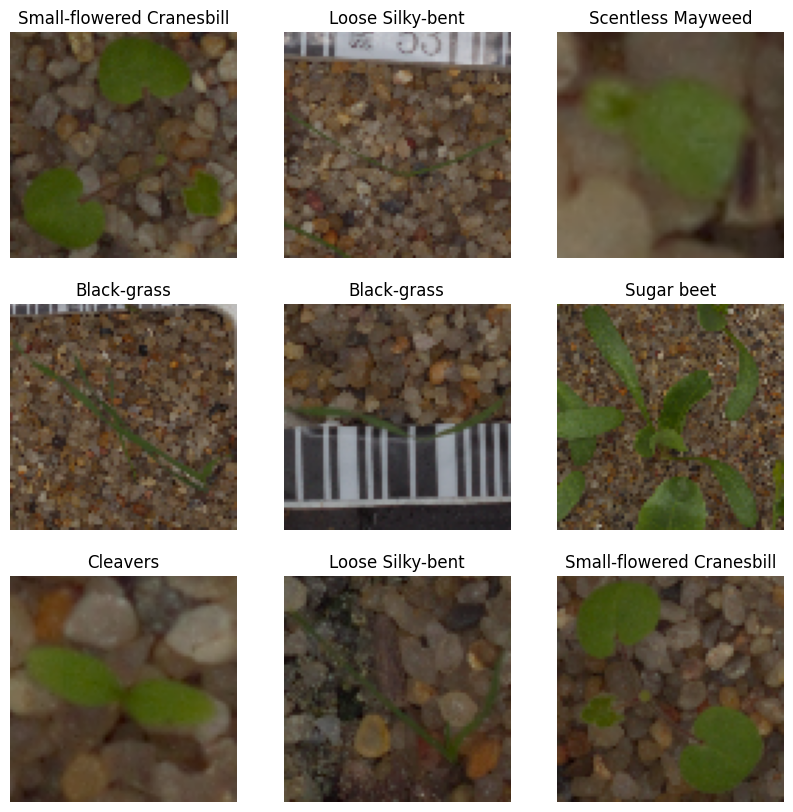

In [9]:
# Plotting some examples from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

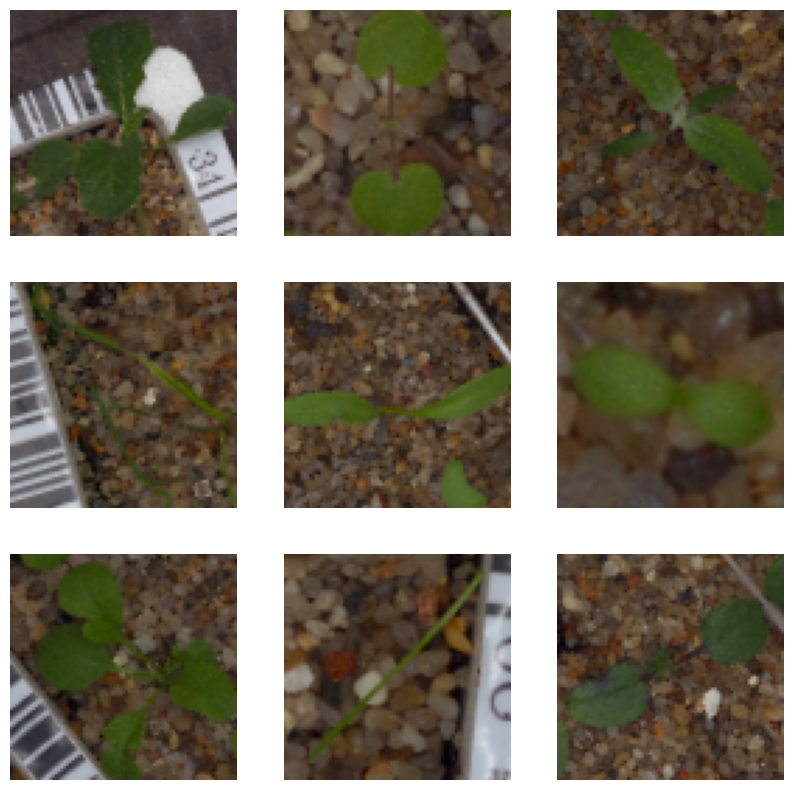

In [10]:
# tf.layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomContrast(0.3)
])

# Applying data augmentation and showing an example
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [11]:
# Using green to create a layer filter

# Reference color in CIELUV space (for green adjustment)
reference_color = tf.convert_to_tensor([40.0, -12.0, 18.0], dtype=tf.float32)

# Define the CIELUV Distance Layer class
class CIELUVDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, reference_color, **kwargs):
        super(CIELUVDistanceLayer, self).__init__(**kwargs)
        self.reference_color = tf.convert_to_tensor(reference_color, dtype=tf.float32)

    def rgb_to_xyz(self, rgb):
        """ Convert RGB to XYZ color space """
        rgb = tf.clip_by_value(rgb, 0.0, 1.0)
        mask = (rgb > 0.04045)
        rgb = tf.where(mask, tf.pow((rgb + 0.055) / 1.055, 2.4), rgb / 12.92)
        rgb = rgb * 100.0
        x = 0.4124 * rgb[..., 0] + 0.3576 * rgb[..., 1] + 0.1805 * rgb[..., 2]
        y = 0.2126 * rgb[..., 0] + 0.7152 * rgb[..., 1] + 0.0722 * rgb[..., 2]
        z = 0.0193 * rgb[..., 0] + 0.1192 * rgb[..., 1] + 0.9505 * rgb[..., 2]
        return tf.stack([x, y, z], axis=-1)

    def xyz_to_cieluv(self, xyz):
        """ Convert XYZ to CIELUV color space """
        ref_x = 95.047
        ref_y = 100.000
        ref_z = 108.883
        x, y, z = xyz[..., 0] / ref_x, xyz[..., 1] / ref_y, xyz[..., 2] / ref_z
        mask = (y > 0.008856)
        L = tf.where(mask, 116.0 * tf.pow(y, 1/3) - 16.0, 903.3 * y)
        u_prime = 4 * x / (x + 15 * y + 3 * z + 1e-7)
        v_prime = 9 * y / (x + 15 * y + 3 * z + 1e-7)
        u_ref = 4 * ref_x / (ref_x + 15 * ref_y + 3 * ref_z)
        v_ref = 9 * ref_y / (ref_x + 15 * ref_y + 3 * ref_z)
        u = 13 * L * (u_prime - u_ref)
        v = 13 * L * (v_prime - v_ref)
        return tf.stack([L, u, v], axis=-1)

    def call(self, inputs):
        inputs = inputs / 255.0  # Normalize inputs to [0, 1] range
        xyz_images = self.rgb_to_xyz(inputs)
        cieluv_images = self.xyz_to_cieluv(xyz_images)
        delta = cieluv_images - self.reference_color
        distance = tf.sqrt(tf.reduce_sum(tf.square(delta), axis=-1, keepdims=True))
        return distance


In [12]:
# Check some properties of the dataset
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")


Images shape: (32, 81, 81, 3)
Labels shape: (32,)
Images shape: (32, 81, 81, 3)
Labels shape: (32,)


In [13]:

# tf.keras.models

# Define the CNN model with more kernels
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Input layer and first convolutional
    model.add(layers.InputLayer(input_shape=input_shape))

    CIELUVDistanceLayer(reference_color=reference_color)

    model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.2))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.2))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.25))

    # Fourth convolutional block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.4))

    # Flatten the 3D feature maps to 1D feature vectors
    model.add(layers.Flatten())
    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Set input shape and number of classes
input_shape = (81, 81, 3)
num_classes = 12

# Create the CNN model
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()

/home/nico/.pyenv/versions/3.10.6/envs/ai_weeder/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 81, 81, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,124 (2.01 MB)

 Trainable params: 526,124 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
epochs = 120

# Train the CNN model
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    #class_weight=class_weights_nb,
    verbose=1,
    # callbacks=[early_stopping],
)


Epoch 1/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0895 - loss: 9.0716 - val_accuracy: 0.0968 - val_loss: 2.4839
Epoch 2/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0763 - loss: 2.4866 - val_accuracy: 0.0708 - val_loss: 2.4850
Epoch 3/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0961 - loss: 2.4857 - val_accuracy: 0.0745 - val_loss: 2.4843
Epoch 4/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.0859 - loss: 2.4851 - val_accuracy: 0.1061 - val_loss: 2.4818
Epoch 5/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1119 - loss: 2.4703 - val_accuracy: 0.1322 - val_loss: 2.3105
Epoch 6/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.1779 - loss: 2.2729 - val_accuracy: 0.2104 - val_loss: 2.1269
Epoch 7/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1968 - loss: 2.1137 - val_accuracy: 0.2775 - val_loss: 1.9467
Epoch 8/120
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2593 - loss: 2.0258 - val_accuracy: 0.

In [15]:
# Evaluate the model and calculate F1 Score
evaluate = cnn_model.evaluate(val_dataset)
evaluate

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8138 - loss: 0.6309


[0.5786716938018799, 0.8026070594787598]

In [16]:
# Evaluate the model and calculate F1 Score
# precision = cnn_model.evaluate(val_dataset)[0]  # only makes sense if we can ouput precision and recall
# recall = cnn_model.evaluate(val_dataset)[1]     # only makes sense if we can ouput precision and recall

# f1_score = 2 * (precision * recall) / (precision + recall)
# print(f"F1 Score: {f1_score}")

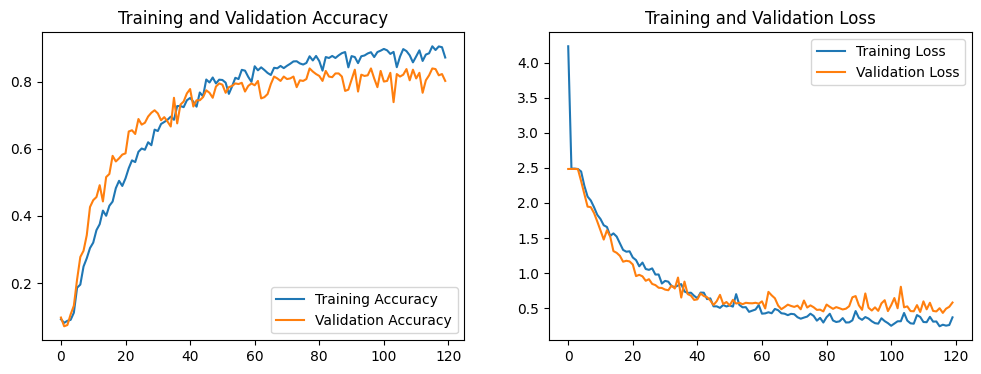

In [17]:
# Retrieve metrics from the history
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Determine the number of epochs actually trained
epochs_trained = len(acc)

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-09-06 14:15:24.578703: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


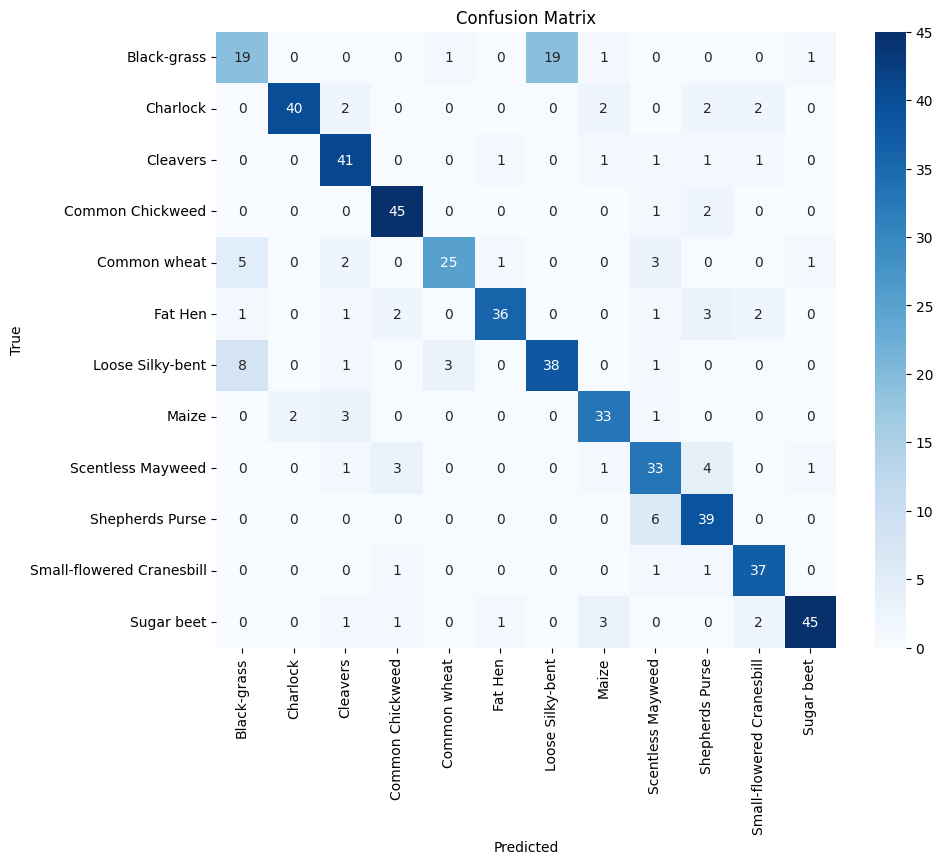

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

# Assuming 'cnn_model' is your trained model and 'val_dataset' is the validation dataset
# Get the true labels and predicted labels from the validation set
true_labels = []
predicted_labels = []

# Loop over the validation set to collect true labels and predictions
for images, labels in val_dataset:
    # Get model predictions
    preds = cnn_model.predict(images)
    # Convert predictions from probabilities to class indices
    predicted_class_indices = np.argmax(preds, axis=1)

    true_labels.extend(labels.numpy())  # Append true labels
    predicted_labels.extend(predicted_class_indices)  # Append predicted labels

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score

# Assuming true_labels and predicted_labels are already calculated as in the previous step

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average=None)  # 'average=None' gives precision per class
recall = recall_score(true_labels, predicted_labels, average=None)        # 'average=None' gives recall per class

# Display precision and recall for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print('-' * 30)

# If you want to calculate the macro or weighted averages for overall precision and recall:
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')

weighted_precision = precision_score(true_labels, predicted_labels, average='weighted')
weighted_recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")


Class: Black-grass
Precision: 0.5757575757575758
Recall: 0.4634146341463415
------------------------------
Class: Charlock
Precision: 0.9523809523809523
Recall: 0.8333333333333334
------------------------------
Class: Cleavers
Precision: 0.7884615384615384
Recall: 0.8913043478260869
------------------------------
Class: Common Chickweed
Precision: 0.8653846153846154
Recall: 0.9375
------------------------------
Class: Common wheat
Precision: 0.8620689655172413
Recall: 0.6756756756756757
------------------------------
Class: Fat Hen
Precision: 0.9230769230769231
Recall: 0.782608695652174
------------------------------
Class: Loose Silky-bent
Precision: 0.6666666666666666
Recall: 0.7450980392156863
------------------------------
Class: Maize
Precision: 0.8048780487804879
Recall: 0.8461538461538461
------------------------------
Class: Scentless Mayweed
Precision: 0.6875
Recall: 0.7674418604651163
------------------------------
Class: Shepherds Purse
Precision: 0.75
Recall: 0.866666666666

In [20]:
# Assuming macro_precision, macro_recall, weighted_precision, weighted_recall are already calculated

# Calculate Macro F1 Score
macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)

# Calculate Weighted F1 Score
weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)

print(f"Macro F1 Score: {macro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")

Macro F1 Score: 0.8015655665699597
Weighted F1 Score: 0.8049398817475493


In [21]:
from sklearn.metrics import f1_score

# Assuming true_labels and predicted_labels are already calculated

# Calculate the F1 score (micro-averaged)
micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

# Calculate the F1 score (weighted, macro, or other averaging methods if needed)
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Micro-Averaged F1 Score: {micro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")
print(f"Macro F1 Score: {macro_f1}")

Micro-Averaged F1 Score: 0.8026070763500931
Weighted F1 Score: 0.8013177144285435
Macro F1 Score: 0.797826275630586


Original images shape: (32, 81, 81, 3)
Transformed images shape: (32, 81, 81, 1)


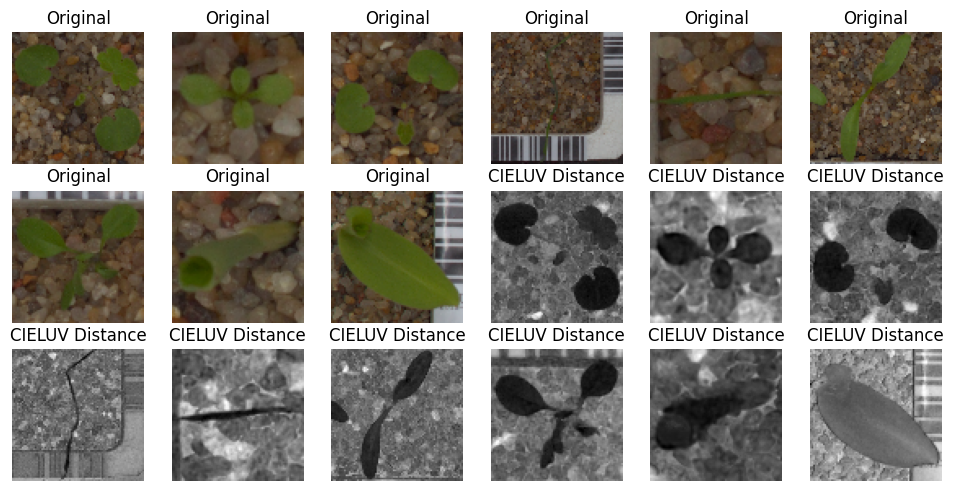

In [22]:
reference_color_test = tf.convert_to_tensor([40.0, -12.0, 18.0], dtype=tf.float32)

def visualize_cieluv_output(dataset, cieluv_layer):
    # Take one batch of images from the dataset
    for images, _ in dataset.take(1):
        # Apply the CIELUV layer
        transformed_images = cieluv_layer(images)

        # Check shapes of the outputs
        print(f"Original images shape: {images.shape}")
        print(f"Transformed images shape: {transformed_images.shape}")

        # Plot the original and transformed images
        plt.figure(figsize=(12, 12))
        for i in range(min(9, images.shape[0])):  # Show up to 9 images
            # Original image
            ax = plt.subplot(6, 6, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Original")
            plt.axis("off")

            # Transformed image
            ax = plt.subplot(6, 6, i + 10)
            # The output of the CIELUV layer is a single channel, so we need to display it as a grayscale image
            plt.imshow(np.squeeze(transformed_images[i].numpy()), cmap='gray')
            plt.title("CIELUV Distance")
            plt.axis("off")

        plt.show()

# Create an instance of the CIELUVDistanceLayer
cieluv_layer = CIELUVDistanceLayer(reference_color=reference_color_test)

# Visualize the output of the CIELUV layer on some images from the training dataset
visualize_cieluv_output(train_dataset, cieluv_layer)

In [24]:
cnn_model.save('my_model_v81_CIELUV_balanced.keras')